# Market Rankings Notebook
Here is the main notebook for the Market Rankings blog post.
## Goal
The goal is to use Amberdata's free API services to select assets for intraday trading. Use this notebook to explore and play around with the data, or the package in this repo to customize the framework for your needs.

In [39]:
# load packages
import requests
import os
import json
from datetime import datetime

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# utility functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("./"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open(".env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception:
        print(response)
        return None
    
api_key = get_key()["AMBERDATA_API_KEY"]

Our first endpoint and the most powerful one for our purposes is [Address Rankings Latest](https://docs.amberdata.io/reference#market-rankings). This gives us key information about available Cryptoassets, and the ability to sort them based on some criteria, set by using `sortType`. Here are our options: 
* changeInPrice
* currentPrice
* liquidMarketCap
* marketCap
* tokenVelocity
* tradeVolume
* transactionVolume
* uniqueAddresses  

Since our goal is intraday trading, we want to make sure we are using high Volume assets, so let us sort by `tradeVolume`.

In [3]:
# the market rankings endpoint
url = "https://web3api.io/api/v2/market/rankings"
# our api key
headers = {'x-api-key': api_key}
# the column to sort by, and number of results to return
querystring = {
    "sortType": "tradeVolume",
    "size": 250
}
# get the results with our utility function
payload = get_response(url, headers, querystring)["data"]

In [4]:
# save the results in a dataframe
# drop not used or redundant columns
df = pd.DataFrame(payload).drop([
    "icon", 
    "maxSupply", 
    "totalSupply", 
    "tokenVelocity", 
    "uniqueAddresses", 
    "transactionVolume",
    "specifications", 
    "address",
    "decimals",
    "circulatingSupply",
    "changeInPrice",
    "rank"
], axis=1)
# make sense of the blockchain column
df["blockchain"] = df.blockchain.map(lambda x: x["name"])
# show results
df.head()

,changeInPriceHourly,changeInPriceDaily,changeInPriceWeekly,currentPrice,marketCap,liquidMarketCap,name,symbol,tradeVolume,blockchain
0,0.11859191312175140200,0.53792841514622718300,-0.65979235557451904100,9238.3850000000000000,170170469681.7450000000000000,170170469681.7450000000000000,Bitcoin,btc,158508516.90415706389750000000000000,Bitcoin
1,0.5270656554844950814681179069178288588400,-1.1407343850201929835907202549192818778800,-13.1112222658356622819948042518073626619100,0.3183046288613750000000000000000000000000,31830462886.1375000000000000000000000000000000...,31830462886.1375000000000000000000000000000000...,Penta Network Token,PNT,39610116.9656703128047818861276375000000000000...,Ethereum
2,0.06641963224498357000,1.05378355956436552300,-2.29124887997610615700,229.0000000000000000,25551421310.7710000000000000000,25551421310.7710000000000000000,Ethereum,eth,35978833.5090734100000000000000000,Ethereum
3,-0.31709345096325943900,0.20683988326296999400,-3.54814956227670657500,0.17683000000000000000,17681396633.93858000000000000000,7826107413.77094000000000000000,XRP,xrp,19575914.38748560097570000000000000000,XRP
4,-0.1742842558410259986312876557363202376400,3.1450708051662265908239758564984339634900,-28.4052510582782903136378361383249565508000,0.0061402925902500000000000000000000000000,6140292.59025000000000000000000000000000000000...,6112418.74233267949398857812500000000000000000...,SeeleToken,Seele,16740504.6005968455870132091530750000000000000...,Ethereum


### Data cleaning
Looks like the data is highly variable in precision. Let's standardize it to `float64`.

In [5]:
non_num = ["name", "symbol", "blockchain"]   # non-numeric columns

# changing numeric columns to float64
df = pd.concat([df[non_num], df.drop(non_num, axis=1).apply(pd.to_numeric, axis=1)], axis=1)
# display results
df.head(10)

,name,symbol,blockchain,changeInPriceHourly,changeInPriceDaily,changeInPriceWeekly,currentPrice,marketCap,liquidMarketCap,tradeVolume
0,Bitcoin,btc,Bitcoin,0.118592,0.537928,-0.659792,9238.385000,1.701705e+11,1.701705e+11,1.585085e+08
1,Penta Network Token,PNT,Ethereum,0.527066,-1.140734,-13.111222,0.318305,3.183046e+10,3.183046e+10,3.961012e+07
2,Ethereum,eth,Ethereum,0.066420,1.053784,-2.291249,229.000000,2.555142e+10,2.555142e+10,3.597883e+07
3,XRP,xrp,XRP,-0.317093,0.206840,-3.548150,0.176830,1.768140e+10,7.826107e+09,1.957591e+07
4,SeeleToken,Seele,Ethereum,-0.174284,3.145071,-28.405251,0.006140,6.140293e+06,6.112419e+06,1.674050e+07
5,Tether USD,USDT,Ethereum,0.009997,0.027496,0.092546,1.000425,6.040414e+09,5.660802e+09,1.279804e+07
6,AcuteAngleCoin,AAC,Ethereum,-1.550884,-9.596124,4.636535,0.046879,4.687903e+07,4.687903e+07,1.248554e+07
7,TrueChain,true,TrueChain,0.093523,-2.517149,-4.621658,0.258208,2.582075e+07,2.054701e+07,1.131115e+07
8,Binance Coin,bnb,Binance Coin,0.109793,2.272891,-1.860264,15.765766,2.836008e+09,2.452155e+09,1.059103e+07
9,The Midas Touch Gold,TMTG,Ethereum,0.986171,2.925373,-42.299543,0.053767,5.124108e+08,5.124108e+08,1.035900e+07


### EDA
Let's take a look at hourly change in price.

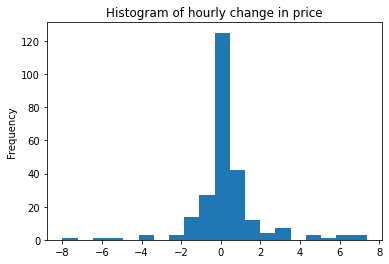

In [6]:
# plotting hourly change in price
df.changeInPriceHourly.plot.hist(bins=20)
plt.title("Histogram of hourly change in price")
plt.savefig("../plots/hour_price_hist.png")

## Define our Universe
Now we have our crucial information to define our asset universe for trading. We care most about:
1. Liquidity, and
2. Volatility [1](https://www.investopedia.com/day-trading/pick-stocks-intraday-trading/).  

Here, we use volume as a proxy for measuring liquidity. We can easily determine volatile stocks with `changeInPrice`. The criteria I developed for picking assets for trading is as follows:
* Assets with `tradeVolume`> $10^6$ to satisfy liquidity.
* Assets to assets with $-5\% <$ `changeInPriceWeekly` $< \%5$ to get assets which have made large moves recently.
* Assets with $-\sigma_H\% <$ `changeInPriceHourly` $< \sigma_H\%$, where $\sigma_H$ is the standard deviation of `changeInPriceHourly` for assets more active than the market.
* Assets with price $< 15\$ $ to reduce barrier of entry.

In [7]:
# get the standard deviation in hourly price change in our data
s = df.changeInPriceHourly.std()
# selecting our asset universe
universe = df.query(f"abs(changeInPriceWeekly) > 5 & tradeVolume > 10**6 & abs(changeInPriceHourly) > {1*s} & currentPrice < 15")
# display our selection
universe

,name,symbol,blockchain,changeInPriceHourly,changeInPriceDaily,changeInPriceWeekly,currentPrice,marketCap,liquidMarketCap,tradeVolume
10,Elrond,erd,Binance Coin,3.129677,6.772839,27.192602,0.006328,1.265659e+08,6.134549e+07,9.790562e+06
15,CVNToken,CVNT,Ethereum,4.614199,9.663359,21.613567,0.012168,1.216788e+07,1.216788e+07,6.479674e+06
27,Chroma,CHR,Ethereum,-3.491126,-0.515192,6.398418,0.032727,1.403017e+07,1.403017e+07,3.386726e+06
32,ELF Token,ELF,Ethereum,-1.881870,-0.253213,-5.593998,0.099663,8.770344e+07,8.770344e+07,2.871419e+06
42,TomoChain,tomo,TomoChain,-1.700628,4.762132,11.889657,0.516657,5.166567e+07,3.676428e+07,1.946565e+06
50,OriginSport Token,ORS,Ethereum,2.196019,-18.921025,78.648369,0.007044,2.113281e+06,2.113281e+06,1.669928e+06
61,Davinci coin,DAC,Ethereum,-3.538844,-10.043135,7.671190,0.010489,9.230551e+07,9.230551e+07,1.382729e+06
75,Solana,sol,Solana,3.327593,-8.135756,12.476044,0.850763,4.157069e+08,1.467453e+07,1.095834e+06
80,XMAX,XMX,Ethereum,4.698350,3.299270,27.149317,0.000760,2.280957e+07,2.280957e+07,1.064562e+06


## Preparing to Trade
Now that we have our day trading assets in order, let's see which are most available to trade. My methodology here is to find out which we can simply buy with USD, which has the lowest transaction fees and barrier to enter. You also may want to consider the VWAP/TWAP of the base you are purchasing.  

First, we get match available pairs to our base's in our asset universe. For more information on a base and quote currencies, check [2](https://www.investopedia.com/terms/b/basecurrency.asp).

In [8]:
# lets get the pairs available to trade
url = "https://web3api.io/api/v2/market/prices/pairs"
# recieve the payload
payload = get_response(url, headers)

In [9]:
# get the base and quote
pairs = [pair.split("_") for pair in payload if len(pair.split("_")) == 2]

In [44]:
# matching the quotes to our selected universe
universe_pairs = {}

for symbol in universe.symbol:
    universe_pairs[symbol.lower()] = [[c for c in p if c != symbol.lower()][0] for p in pairs if symbol.lower() in p]
    
universe_pairs

{'erd': ['bnb', 'btc', 'pax', 'usdc', 'usdt'],
 'cvnt': ['btc', 'eth'],
 'chr': ['krw'],
 'elf': ['btc', 'eth', 'krw', 'usd', 'usdt'],
 'tomo': ['bnb', 'btc', 'usdc', 'usdt'],
 'ors': ['btc', 'eth', 'usd', 'usdt'],
 'dac': ['btc', 'eth', 'krw'],
 'sol': [],
 'xmx': ['btc', 'eth']}

### Note
the code below is only necessary to prove to yourself that the best way to buy alt-coins - if not with USD - is with BTC.

In [11]:
# get a list of all possible 
quotes_all = list(set([item for sublist in list(universe_pairs.values()) for item in sublist]))

In [12]:
currency = "usd"

def get_quotes_data(quotes_all):
    "returns the TWAP/VWAP for our quotes"
    # storing TWAP/VWAP
    quotes_data = {}
    for quote in quotes_all:
        # skip our native currency
        if quote == currency:
            continue
        # getting the WAP data
        url = f"https://web3api.io/api/v2/market/prices/{quote}/wap/latest"
        wap = get_response(url, headers)
        # try to find a pair for our currency
        try:
            quotes_data[quote] = wap[f"{quote}_{currency}"]
        except KeyError:
            print(f"Unable to purchase {quote} with {currency.upper()}")
            continue
        print(f"Able to purchase {quote} with {currency.upper()}")
    return quotes_data

quotes_data = get_quotes_data(quotes_all)

Able to purchase btc with USD
Unable to purchase krw with USD
Unable to purchase bnb with USD
Able to purchase eth with USD
Able to purchase pax with USD
Able to purchase usdt with USD
Able to purchase usdc with USD


In [13]:
# Now, we rank the quotes by VWAP to see which quotes it makes most sense to use to buy
# the underlying we would like to trade
quotes_df = pd.DataFrame(quotes_data).T.sort_values(by="vwap1m", ascending=False).reset_index().rename({"index": "symbol"}, axis=1)
quotes_df

,symbol,timestamp,twap1m,twap5m,twap60m,vwap1m,vwap5m,vwap60m
0,btc,1593617400000,9238.1527020757020757,9239.1652492025161284,9235.0195114359069603,9235.892760137143550125055220,9238.18773242527298521106510565,9236.73816418660550631259206138
1,eth,1593617400000,228.9136859569992997,228.9955371899435028,229.0354253662835535,228.980854588741706143412566,228.996258736333861325844979,229.066883508075630988491242
2,usdt,1593617400000,1.00049852941176470588,1.00048556385517169831,1.00036157310208439164,1.000653101004340961844766,1.0006244657358059099504679424,1.0002385030299405468833069739
3,pax,1593612540000,1.00062000000000000000,1.00062000000000000000,1.00056625000000000000,1.000620000000000000000,1.000620000000000000000,1.000546229404645783161
4,usdc,1593617220000,1.00035714285714285714,1.00035714285714285714,1.00044379699248120301,1.0003759325619519345900000000,1.0003759325619519345900000000,1.0002726181166804964843388305


Now, we continue with our analysis.

### Finally, let's identify our base's
We are assuming that you do not have cryptocurrency to trade for these bases, and you would either have to buy them directly or buy them with Bitcoin.

In [14]:
def get_wap_data(base, quote):
    "returns the TWAP/VWAP for our quotes"
    # getting the WAP data
    url = f"https://web3api.io/api/v2/market/prices/{base}/wap/latest"
    wap = get_response(url, headers)
    if not wap:
        print(f"No WAP data for {base}")
        return {}
    # try to find a pair for our currency
    try:
        return wap[f"{base}_{quote}"]
    except KeyError:
        print(f"Error getting WAP data for {base}")
        return {}

In [28]:
# assume BTC is the best way to buy a coin if we cannot do
# so with our native currency
## arrays to store results
curr_avail, curr_wap = [], []
best_symb, best_wap = [], []
# which we have to buy with BTC, and which to buy with our currency
for base, quotes in universe_pairs.items():
    if currency in quotes:
        curr_avail.append(base)
        curr_wap.append(get_wap_data(base, currency))
    else:
        if "btc" in quotes:
            best_symb.append(base)
            best_wap.append(get_wap_data(base, "btc"))
# display the results
cols = ["name", "symbol", "changeInPriceHourly", "currentPrice", "tradeVolume"]
if curr_wap:
    curr_wap = pd.DataFrame(curr_wap)
if best_wap:
    best_wap = pd.DataFrame(best_wap)

if curr_avail:
    print("\nBase available to buy with fiat:")
    fiat = df[df.symbol.map(lambda x: x.lower()).isin(curr_avail)][cols].reset_index(drop=True).join(curr_wap)
    print(fiat)
else:
    print("\nUnable to purchase any bases with fiat")
print(f"\nAble to purchase with btc:")
btc = df[df.symbol.map(lambda x: x.lower()).isin(best_symb)][cols].reset_index(drop=True).join(best_wap)
print(btc)

No WAP data for cvnt
No WAP data for ors
No WAP data for dac
No WAP data for xmx

Base available to buy with fiat:
                name symbol  changeInPriceHourly  currentPrice   tradeVolume  \
0          ELF Token    ELF            -1.881870      0.099663  2.871419e+06   
1  OriginSport Token    ORS             2.196019      0.007044  1.669928e+06   

      timestamp                  twap1m                  twap5m  \
0  1.593617e+12  0.09720000000000000000  0.09720000000000000000   
1           NaN                     NaN                     NaN   

                  twap60m                   vwap1m                   vwap5m  \
0  0.09720000000000000000  0.097200000000000000000  0.097200000000000000000   
1                     NaN                      NaN                      NaN   

                   vwap60m  
0  0.097200000000000000000  
1                      NaN  

Able to purchase with btc:
           name symbol  changeInPriceHourly  currentPrice   tradeVolume  \
0        Elron

In [42]:
# save the results
now = datetime.now().strftime("%y-%m-%d_%H-%M")
fiat.to_csv(f"../results/{now}_fiat.csv", index=False)
btc.to_csv(f"../results/{now}_btc.csv", index=False)